In [67]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("demo").getOrCreate()
import matplotlib.pyplot as plt

In [62]:
schema_ratings = StructType([
    StructField("Id",IntegerType()),
    StructField("userId",IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", DoubleType()),
    StructField("timestamp",StringType())    
])
ratings_df = spark.read.format("csv").option("header", "true").schema(schema_ratings).load("file:////home/nhatthanh123bk/Desktop/app/data/ratings.csv")
print("Table ratings:")
ratings_df.show()


Table ratings:
+---+------+-------+------+---------+
| Id|userId|movieId|rating|timestamp|
+---+------+-------+------+---------+
|  0|     1|   1193|   5.0|978300760|
|  1|     1|    661|   3.0|978302109|
|  2|     1|    914|   3.0|978301968|
|  3|     1|   3408|   4.0|978300275|
|  4|     1|   2355|   5.0|978824291|
|  5|     1|   1197|   3.0|978302268|
|  6|     1|   1287|   5.0|978302039|
|  7|     1|   2804|   5.0|978300719|
|  8|     1|    594|   4.0|978302268|
|  9|     1|    919|   4.0|978301368|
| 10|     1|    595|   5.0|978824268|
| 11|     1|    938|   4.0|978301752|
| 12|     1|   2398|   4.0|978302281|
| 13|     1|   2918|   4.0|978302124|
| 14|     1|   1035|   5.0|978301753|
| 15|     1|   2791|   4.0|978302188|
| 16|     1|   2687|   3.0|978824268|
| 17|     1|   2018|   4.0|978301777|
| 18|     1|   3105|   5.0|978301713|
| 19|     1|   2797|   4.0|978302039|
+---+------+-------+------+---------+
only showing top 20 rows



In [59]:
print("Total number of ratings: ",ratings_df.count())
print("Total number of people participating in the ratings:",ratings_df.select("userId").distinct().count())
print("Total number of movies:",ratings_df.select("movieId").distinct().count())

('Total number of ratings: ', 1000209)
('Total number of people participating in the ratings:', 6040)
('Total number of movies:', 3706)


Rating probability distribution table.


,rating,count
0,1.0,56174
1,2.0,107557
2,5.0,226310
3,3.0,261197
4,4.0,348971


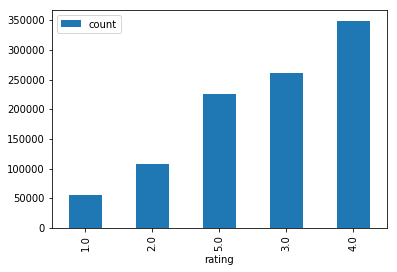

In [98]:
print("Rating probability distribution table.")
distribution_rating = ratings_df.groupby("rating").count().sort("count")
dr = distribution_rating.toPandas()
dr.plot(x="rating",y="count",kind='bar')
dr

In [74]:
print("On average, each participant rated 165 films.")
ratings_df.groupby("userId").count().describe("count").show()

On average, each participant rated 165 films.
+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              6040|
|   mean| 165.5975165562914|
| stddev|192.74702906977777|
|    min|                20|
|    max|              2314|
+-------+------------------+



In [80]:
schema_movies = StructType([
    StructField("Id",IntegerType()),
    StructField("movieId",IntegerType()),
    StructField("title",StringType()),
    StructField("genres",StringType())    
])
movies_df = spark.read.format("csv").option("header", "true").schema(schema_movies).load("file:////home/nhatthanh123bk/Desktop/app/data/movies.csv")
movies_df.show(10)

+---+-------+--------------------+--------------------+
| Id|movieId|               title|              genres|
+---+-------+--------------------+--------------------+
|  0|      1|    Toy Story (1995)|Animation|Childre...|
|  1|      2|      Jumanji (1995)|Adventure|Childre...|
|  2|      3|Grumpier Old Men ...|      Comedy|Romance|
|  3|      4|Waiting to Exhale...|        Comedy|Drama|
|  4|      5|Father of the Bri...|              Comedy|
|  5|      6|         Heat (1995)|Action|Crime|Thri...|
|  6|      7|      Sabrina (1995)|      Comedy|Romance|
|  7|      8| Tom and Huck (1995)|Adventure|Children's|
|  8|      9| Sudden Death (1995)|              Action|
|  9|     10|    GoldenEye (1995)|Action|Adventure|...|
+---+-------+--------------------+--------------------+
only showing top 10 rows



In [81]:
from pyspark.sql import functions as F
genres = F.split(movies_df["genres"],"\|")
movies_df = movies_df.withColumn("genres",genres)
movies_df.show()

+---+-------+--------------------+--------------------+
| Id|movieId|               title|              genres|
+---+-------+--------------------+--------------------+
|  0|      1|    Toy Story (1995)|[Animation, Child...|
|  1|      2|      Jumanji (1995)|[Adventure, Child...|
|  2|      3|Grumpier Old Men ...|   [Comedy, Romance]|
|  3|      4|Waiting to Exhale...|     [Comedy, Drama]|
|  4|      5|Father of the Bri...|            [Comedy]|
|  5|      6|         Heat (1995)|[Action, Crime, T...|
|  6|      7|      Sabrina (1995)|   [Comedy, Romance]|
|  7|      8| Tom and Huck (1995)|[Adventure, Child...|
|  8|      9| Sudden Death (1995)|            [Action]|
|  9|     10|    GoldenEye (1995)|[Action, Adventur...|
| 10|     11|American Presiden...|[Comedy, Drama, R...|
| 11|     12|Dracula: Dead and...|    [Comedy, Horror]|
| 12|     13|        Balto (1995)|[Animation, Child...|
| 13|     14|        Nixon (1995)|             [Drama]|
| 14|     15|Cutthroat Island ...|[Action, Adven

,genres,count
0,Mystery,106
1,Romance,471
2,Sci-Fi,276
3,Children's,251
4,Horror,343
5,Film-Noir,44
6,Crime,211
7,Drama,1603
8,Fantasy,68
9,Animation,105


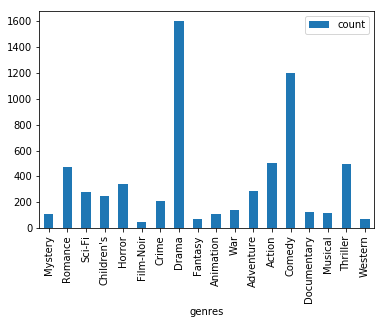

In [91]:
genres_df = movies_df.select("genres")
genres_rdd = genres_df.rdd.flatMap(lambda a: [(w,1) for w in a.genres]).reduceByKey(lambda a,b: a+b)
genres_df = spark.createDataFrame(genres_rdd,["genres","count"])
genres_df.toPandas().plot(x = "genres",y = "count",kind='bar')
genres_df.toPandas()

In [99]:
ratings_df.select('*',movie)

AnalysisException: u'Resolved attribute(s) genres#1970 missing from userId#1229,movieId#1230,rating#1231,Id#1228,timestamp#1232 in operator !Project [Id#1228, userId#1229, movieId#1230, rating#1231, timestamp#1232, genres#1970 AS genres#2196].;;\n!Project [Id#1228, userId#1229, movieId#1230, rating#1231, timestamp#1232, genres#1970 AS genres#2196]\n+- Relation[Id#1228,userId#1229,movieId#1230,rating#1231,timestamp#1232] csv\n'